In [45]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
# LOADING DATASET AND DATA PREPROCESSING

# Define data directories
train_data = '/Users/m1/Downloads/Chest xray dataset 2/train'
validation_data = '/Users/m1/Downloads/Chest xray dataset 2/val'
test_data = '/Users/m1/Downloads/Chest xray dataset 2/test'

# Define image dimensions and batch size for training
img_width, img_height = 224, 224
batch_size = 32

# Define batch size for validation
batch_size_val = 4

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                   # Rescale pixel values to [0,1]
    rotation_range=20,                # Random rotation within range
    width_shift_range=0.2,            # Random horizontal shift
    height_shift_range=0.2,           # Random vertical shift
    shear_range=0.2,                  # Shear transformation
    zoom_range=0.2,                   # Random zoom
    horizontal_flip=True,             # Random horizontal flip
    fill_mode='nearest'               # Fill mode for new pixels
)

# Data preprocessing for validation and test data (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_data,                       # Directory containing training images
    target_size=(img_width, img_height),  # Resize images to specified dimensions
    batch_size=batch_size,           # Batch size for training
    class_mode='categorical'         # Class mode for categorical classification
)

# Flow validation images in batches using ImageDataGenerator
validation_generator = validation_datagen.flow_from_directory(
    validation_data,                  # Directory containing validation images
    target_size=(img_width, img_height),  # Resize images to specified dimensions
    batch_size=batch_size_val,       # Batch size for validation
    class_mode='categorical'         # Class mode for categorical classification
)

# Flow test images in batches using ImageDataGenerator
test_generator = test_datagen.flow_from_directory(
    test_data,                       # Directory containing test images
    target_size=(img_width, img_height),  # Resize images to specified dimensions
    batch_size=batch_size,           # Batch size for testing
    class_mode='categorical'         # Class mode for categorical classification
)


Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


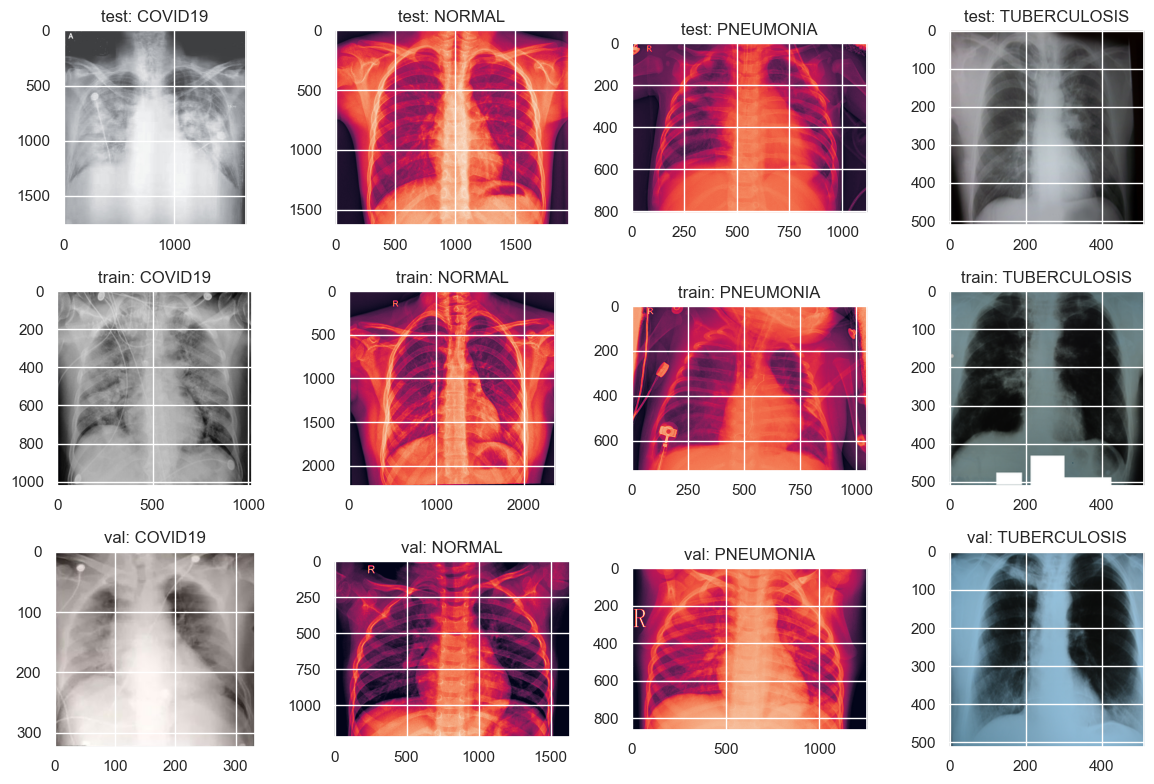

In [47]:
# VIEWING PREPROCESSED DATA

# Define the path to the dataset
dataset = '/Users/m1/Downloads/Chest xray dataset 2'

# Define the subfolders containing the images
subfolders = ['test', 'train', 'val']
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

# Display an example image from each class
fig, axs = plt.subplots(len(subfolders), len(classes), figsize=(12, 8))

# Loop over each subset (test, train, val)
for i, subset in enumerate(subfolders):
    # Loop over each class (COVID19, NORMAL, PNEUMONIA, TUBERCULOSIS)
    for j, class_name in enumerate(classes):
        # Get the list of image filenames in the current folder
        folder_path = os.path.join(dataset, subset, class_name)
        filenames = os.listdir(folder_path)
        
        # Read and display the first image in the folder
        img_path = os.path.join(folder_path, filenames[0])
        img = imread(img_path)
        axs[i, j].imshow(img)  # Display the image
        axs[i, j].set_title(f'{subset}: {class_name}')  # Set title with subset and class name

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [48]:
# CNN Model Architecture Definition

# Initialize the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))  # 32 filters, each with a 3x3 kernel, ReLU activation, input shape matching image dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling with 2x2 pool size

model.add(Conv2D(64, (3, 3), activation='relu'))  # 64 filters, each with a 3x3 kernel, ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling with 2x2 pool size

model.add(Conv2D(128, (3, 3), activation='relu'))  # 128 filters, each with a 3x3 kernel, ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling with 2x2 pool size

model.add(Conv2D(128, (3, 3), activation='relu'))  # 128 filters, each with a 3x3 kernel, ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling with 2x2 pool size

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))  # Dense layer with 512 units, ReLU activation

# Dropout for regularization
model.add(Dropout(0.5))  # Dropout with a rate of 0.5 (50% probability of dropout)

# Output layer with softmax activation for multiclass classification (4 classes)
model.add(Dense(4, activation='softmax'))  # Output layer with 4 units and softmax activation

# Compile the model
# Define a custom F1-score metric
def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + keras.backend.epsilon()))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])

# Display the model summary
model.summary()


/Users/m1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,680,580 (36.93 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Training the Model

# Define the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // batch_size  # Number of steps per epoch for training data
validation_steps_per_epoch = validation_generator.samples // batch_size_val  # Number of steps per epoch for validation data

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_steps_per_epoch,  # Number of steps per epoch for training data
    epochs=5,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    validation_steps=validation_steps_per_epoch,  # Number of steps per epoch for validation data
    verbose=1  # Verbosity mode. Set to 1 to print training progress
)

# Print validation logs after each epoch
print("Validation logs after each epoch:")
print(history.history)  # Display history object containing training and validation metrics


Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 165s 826ms/step - accuracy: 0.8705 - f1_score: 0.2168 - loss: 0.3271 - precision_3: 0.8868 - recall_3: 0.8520 - val_accuracy: 0.8056 - val_f1_score: 0.2024 - val_loss: 0.4873 - val_precision_3: 0.8235 - val_recall_3: 0.7778
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 222us/step - accuracy: 0.8750 - f1_score: 0.2105 - loss: 0.3553 - precision_3: 0.9000 - recall_3: 0.8438 - val_accuracy: 1.0000 - val_f1_score: 0.2481 - val_loss: 0.0156 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/5


2024-04-25 14:28:41.156168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/m1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-25 14:28:41.182587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


197/197 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8786 - f1_score: 0.2187 - loss: 0.3111 - precision_3: 0.8878 - recall_3: 0.8645 - val_accuracy: 0.8611 - val_f1_score: 0.2107 - val_loss: 0.3630 - val_precision_3: 0.8611 - val_recall_3: 0.8611
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - accuracy: 0.9688 - f1_score: 0.2356 - loss: 0.1179 - precision_3: 0.9688 - recall_3: 0.9688 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0532 - val_loss: 2.1775 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/5


2024-04-25 14:32:10.714892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 14:32:10.761345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


197/197 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8844 - f1_score: 0.2209 - loss: 0.2824 - precision_3: 0.8959 - recall_3: 0.8707 - val_accuracy: 0.6944 - val_f1_score: 0.1833 - val_loss: 0.7712 - val_precision_3: 0.6857 - val_recall_3: 0.6667
Validation logs after each epoch:
{'accuracy': [0.872894823551178, 0.875, 0.8846520781517029, 0.96875, 0.8897362351417542], 'f1_score': [0.2173835188150406, 0.21050599217414856, 0.2196401059627533, 0.23563554883003235, 0.22155232727527618], 'loss': [0.32463547587394714, 0.35532286763191223, 0.30325624346733093, 0.11791025102138519, 0.28275036811828613], 'precision_3': [0.8869879841804504, 0.8999999761581421, 0.895846962928772, 0.96875, 0.901650071144104], 'recall_3': [0.856688916683197, 0.84375, 0.8705115914344788, 0.96875, 0.87686687707901], 'val_accuracy': [0.8055555820465088, 1.0, 0.8611111044883728, 0.0, 0.6944444179534912], 'val_f1_score': [0.2024461179971695, 0.24805010855197906, 0.21069961786270142, 0.05320613086223602, 0.18333975970

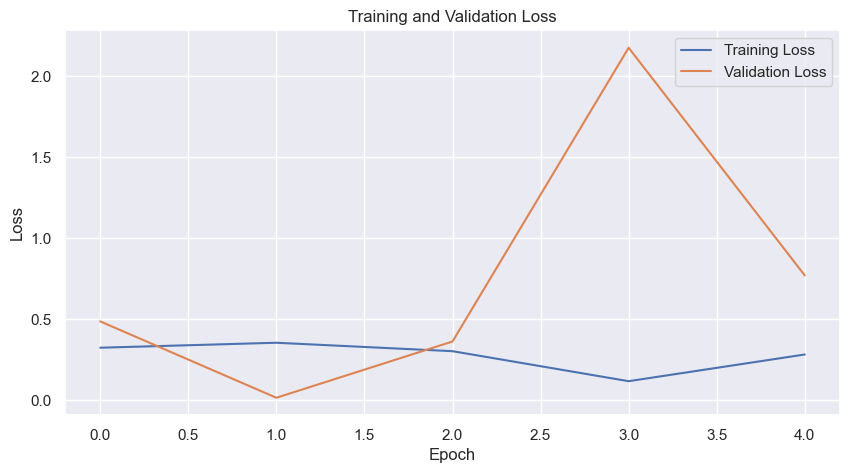

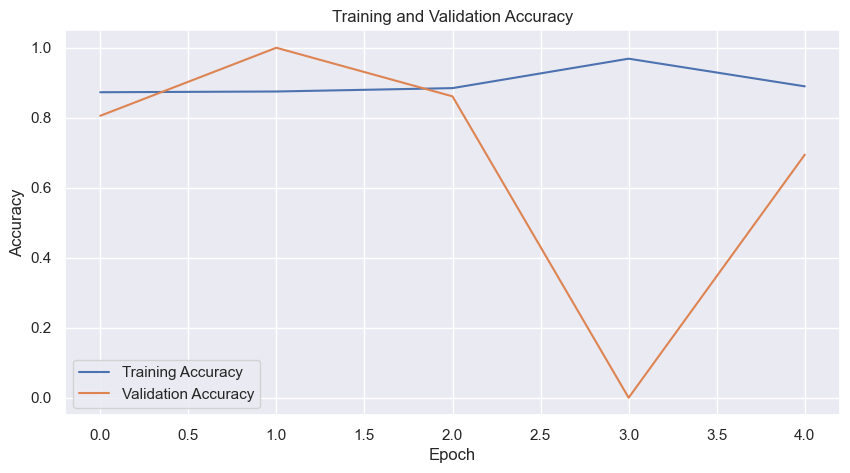

In [57]:
# Plotting training history

# Get training and validation metrics from the history object
training_loss = history.history['loss']  # Training loss values
validation_loss = history.history['val_loss']  # Validation loss values
training_accuracy = history.history['accuracy']  # Training accuracy values
validation_accuracy = history.history['val_accuracy']  # Validation accuracy values

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')  # Plot training loss
plt.plot(validation_loss, label='Validation Loss')  # Plot validation loss
plt.title('Training and Validation Loss')  # Set title
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')  # Plot training accuracy
plt.plot(validation_accuracy, label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Set title
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Accuracy')  # Set y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.7786 - f1_score: 0.1977 - loss: 0.5457 - precision_3: 0.7845 - recall_3: 0.7683
Test Loss: 0.45211169123649597
Test Accuracy: 0.8159999847412109
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step


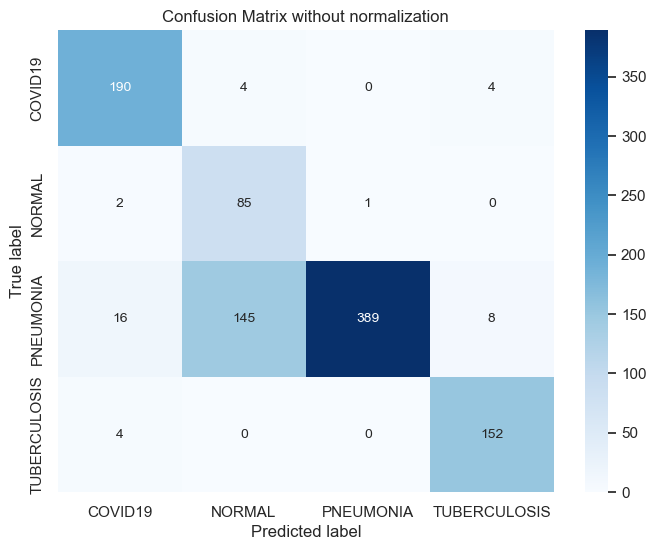

In [58]:
# Evaluate the model on the test set
test_evaluation = model.evaluate(test_generator)

# Print the test evaluation results
print("Test Loss:", test_evaluation[0])
print("Test Accuracy:", test_evaluation[1])

# Load model predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes for the test set
true_classes = test_generator.classes

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(predicted_classes, true_classes)

# Plot the confusion matrix without normalization
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.0)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap=plt.cm.Blues)
plt.title('Confusion Matrix without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [60]:
# Definition of file path 
NN_model = '/Users/m1/Documents/Models.h5'  # Define the file path where the model will be saved

# Save the model to a file
model.save(NN_model)  # Save the model to the specified file path

# Print confirmation message
print("Model saved successfully!")  # Print a message indicating that the model was saved successfully


Model saved successfully!
